# 4501 final project

## Project Setup

In [8]:
import os
import re
import pandas as pd
import numpy as np
import requests
import math
from bs4 import BeautifulSoup
import geopandas as gpd
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as pltx
from urllib.parse import urljoin
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")

In [9]:

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise


## Part 1: Data Preprocessing

### Download

Define a function download_file(link, save_dir) that efficiently download files ensuring that no duplicate downloads occur if the file already exists in the target directory and Saves the file in chunks of 8192 bytes to avoid memory overload.

In [10]:
# Local directory to save downloaded files
download_dir = "./nyc_taxi_data"
os.makedirs(download_dir, exist_ok=True)

# Function to download a file
def download_file(link, save_dir):
    file_name = link.split("/")[-1]
    file_path = os.path.join(save_dir, file_name)
    # Skip download if the file already exists
    if not os.path.exists(file_path):  
        print(f"Downloading {file_name}...")
        response = requests.get(link, stream=True)
        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Saved to {file_path}")
    else:
        print(f"{file_name} already exists. Skipping download.")
    return file_path

* Scraping a webpage for links to Yellow Taxi and HVFHV Parquet data files.
* Downloading only the relevant files based on naming patterns and storing them locally.

In [11]:
# Fetch the webpage content
response = requests.get(TLC_URL)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    raise Exception("Failed to fetch the TLC page.")

# Regular expressions to match Yellow Taxi and HVFHV links
yellow_taxi_regex = re.compile(r"yellow_tripdata_(202[0-4])-(0[1-9]|1[0-2])\.parquet", re.IGNORECASE)
hvfhv_regex = re.compile(r"fhvhv_tripdata_(202[0-4])-(0[1-9]|1[0-2])\.parquet", re.IGNORECASE)

# Find all links on the page
links = soup.find_all('a', href=True)

# File path
taxi_path = []
hvfhv_path = []

# Filter and download Yellow Taxi and HVFHV Parquet files
taxi_path, hvfhv_path = [], []
for link in soup.find_all("a", href=True):
    url = urljoin("https://www1.nyc.gov", link["href"].strip())
    if yellow_taxi_regex.search(url):
        taxi_path.append(download_file(url, download_dir))
    elif hvfhv_regex.search(url):
        hvfhv_path.append(download_file(url, download_dir))
                

yellow_tripdata_2024-01.parquet already exists. Skipping download.
fhvhv_tripdata_2024-01.parquet already exists. Skipping download.
yellow_tripdata_2024-02.parquet already exists. Skipping download.
fhvhv_tripdata_2024-02.parquet already exists. Skipping download.
yellow_tripdata_2024-03.parquet already exists. Skipping download.
fhvhv_tripdata_2024-03.parquet already exists. Skipping download.
yellow_tripdata_2024-04.parquet already exists. Skipping download.
fhvhv_tripdata_2024-04.parquet already exists. Skipping download.
yellow_tripdata_2024-05.parquet already exists. Skipping download.
fhvhv_tripdata_2024-05.parquet already exists. Skipping download.
yellow_tripdata_2024-06.parquet already exists. Skipping download.
fhvhv_tripdata_2024-06.parquet already exists. Skipping download.
yellow_tripdata_2024-07.parquet already exists. Skipping download.
fhvhv_tripdata_2024-07.parquet already exists. Skipping download.
yellow_tripdata_2024-08.parquet already exists. Skipping download.
fh

### Load Taxi Zones

* The first function (load_taxi_zones) processes and prepares taxi zone data from a shapefile for geospatial analysis.
* The second function (lookup_coords_for_taxi_zone_id) finds the latitude and longitude coordinates of a taxi zone based on its LocationID.

In [12]:
def load_taxi_zones(shapefile_path):
    taxi_zones = gpd.read_file(shapefile_path)
    taxi_zones = taxi_zones.to_crs(4326)  # Reproject to lat/lon (WGS84)
    taxi_zones['lon'] = taxi_zones.centroid.x  # Calculate longitude from centroid
    taxi_zones['lat'] = taxi_zones.centroid.y  # Calculate latitude from centroid
    return taxi_zones

In [13]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]
    if not zone.empty:
        return zone.iloc[0]['lat'], zone.iloc[0]['lon']
    return None, None  # Return None if the location ID is invalid

### Calculate Sample Size

Create a representative sample using Cochran's Sample Size Formula

In [14]:
def calculate_sample_size(population, margin_of_error=0.05):
    z = 1.96  # For 95% confidence
    p = 0.5  # Assumed proportion of 50% (worst-case scenario)
    q = 1 - p
    e = margin_of_error
    pop = population.shape[0]
    # Cochran's sample size formula
    sample_size = (z ** 2 * p * q) / (e ** 2)
    # Adjust sample size for finite population
    sample_size = sample_size / (1 + (sample_size - 1) / pop)
    sampled_df = population.sample(n=math.ceil(sample_size), random_state=42)
    return sampled_df

### Common Functions

Append latitude and longitude coordinates for pickup and drop-off locations to taxi_data DataFrame by mapping them from a preloaded taxi zones dataset.

In [15]:
def add_coordinates_to_taxi_data(taxi_data, loaded_taxi_zones):
    taxi_data[['PUlat', 'PUlon']] = taxi_data['PULocationID'].apply(
        lambda x: pd.Series(lookup_coords_for_taxi_zone_id(x, loaded_taxi_zones))
    )
    taxi_data[['DOlat', 'DOlon']] = taxi_data['DOLocationID'].apply(
        lambda x: pd.Series(lookup_coords_for_taxi_zone_id(x, loaded_taxi_zones))
    )
    taxi_data = taxi_data.drop(columns=['PULocationID', 'DOLocationID'])
    return taxi_data

### Process Taxi Data

1. Load Data: Reads a Parquet file specified by path into a pandas DataFrame using pd.read_parquet().

2. Initial Filtering:
 - Removes trips with zero or negative distances (trip_distance > 0).
 - Excludes trips where the pickup and drop-off locations are the same (PULocationID != DOLocationID).
 - Ensures the PULocationID and DOLocationID values are within the valid range of 1–263 .

3. Handle Missing Data: Drops rows with missing values in the trip_distance, PULocationID, or DOLocationID columns.

4. Sampling: Calculates the required sample size using calculate_sample_size() and selects a random sample from the dataset.

5. Add Geographic Coordinates: Enriches the dataset by adding latitude and longitude columns for both pickup and drop-off locations using the add_coordinates_to_taxi_data() function.

6. Filter by Geographic Boundaries: Filters trips to ensure pickup and drop-off locations are within specific latitude and longitude ranges.

7. Remove Unnecessary Columns: Drops columns that are not relevant for further analysis, such as: RatecodeID, store_and_fwd_flag, payment_type, extra


In [16]:
def get_and_clean_month(path, loaded_taxi_zones):
    a = pd.read_parquet(path)
    a = a[(a['trip_distance'] > 0) & (a['PULocationID'] != a['DOLocationID'])]
    # Ensures the PULocationID and DOLocationID values are within the valid range of 1–263
    a = a[(a['PULocationID'] >= 1) & (a['PULocationID'] <= 263)]
    a = a[(a['DOLocationID'] >= 1) & (a['DOLocationID'] <= 263)]
    # drop nan
    a = a.dropna(subset=['trip_distance', 'PULocationID', 'DOLocationID'])  
    # get sample
    a = calculate_sample_size(a)
    # Convert ID to lat lon
    a = add_coordinates_to_taxi_data(a, loaded_taxi_zones)
    # Filter by latitude
    a = a[a['PUlat'].between(40.560445, 40.908524)] 
    a = a[a['DOlat'].between(40.560445, 40.908524)] 
    # Filter by longitude
    a = a[a['PUlon'].between(-74.242330, -73.717047)] 
    a = a[a['DOlon'].between(-74.242330, -73.717047)]  
    a = a.drop(['RatecodeID', 'store_and_fwd_flag', 'payment_type', 
             'extra'], axis=1)
    # more clean step
    return a

* Cleaning each file individually.
* Merging all the cleaned files into a single DataFrame.

In [17]:
def get_and_clean_taxi_data(parquet_urls):
    all_taxi_dataframes = []
    loaded_taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
    for parquet_url in tqdm(parquet_urls):
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month(parquet_url, loaded_taxi_zones)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        all_taxi_dataframes.append(dataframe.sort_values(by='tpep_pickup_datetime', ascending=True))  
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)
    return taxi_data

Return a cleaned and combined dataset of taxi trip data

In [18]:
def get_taxi_data():
    taxi_path.sort()
    taxi_data = get_and_clean_taxi_data(taxi_path)
    return taxi_data

In [19]:
taxi_data = get_taxi_data()

100%|██████████| 57/57 [00:54<00:00,  1.05it/s]


In [20]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUlat,PUlon,DOlat,DOlon,Airport_fee
0,1,2020-01-01 00:56:39,2020-01-01 01:21:13,2.0,3.80,16.5,0.5,0.00,0.0,0.3,20.30,2.5,NaN,40.756729,-73.965146,40.712459,-73.998151,NaN
1,1,2020-01-01 02:09:23,2020-01-01 02:24:08,3.0,3.30,13.0,0.5,3.35,0.0,0.3,20.15,2.5,NaN,40.736824,-73.984052,40.775932,-73.946510,NaN
2,2,2020-01-01 02:35:25,2020-01-01 03:06:56,1.0,6.82,25.5,0.5,5.86,0.0,0.3,35.16,2.5,NaN,40.756729,-73.965146,40.761493,-73.919694,NaN
3,2,2020-01-01 03:11:10,2020-01-01 03:23:52,6.0,6.91,21.0,0.5,4.96,0.0,0.3,29.76,2.5,NaN,40.766238,-73.995135,40.841709,-73.941399,NaN
4,1,2020-01-01 03:49:45,2020-01-01 03:59:46,2.0,1.40,8.5,0.5,0.00,0.0,0.3,9.80,0.0,NaN,40.804334,-73.951292,40.818258,-73.940772,NaN


Adjust columns' names

In [21]:
new_column_names = {
    'VendorID': 'vendor_id',
    'tpep_pickup_datetime': 'pickup_time',
    'tpep_dropoff_datetime': 'dropoff_time',
    'passenger_count': 'passenger_count',
    'trip_distance': 'trip_distance',
    'fare_amount': 'fare_amount',
    'mta_tax': 'tax',
    'tip_amount': 'tip',
    'tolls_amount': 'tolls',
    'improvement_surcharge' : 'imp_surcharge',
    'total_amount': 'total_amount',
    'congestion_surcharge':'con_surcharge',
    'airport_fee': 'airport_fee',
    'PUlat':'pickup_lat',
    'PUlon':'pickup_lon',
    'DOlat':'dropoff_lat',
    'DOlon':'dropoff_lon',
    'Airport_fee':'fee'
}

taxi_data = taxi_data.rename(columns=new_column_names)

In [22]:
taxi_data.head()

,vendor_id,pickup_time,dropoff_time,passenger_count,trip_distance,fare_amount,tax,tip,tolls,imp_surcharge,total_amount,con_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,fee
0,1,2020-01-01 00:56:39,2020-01-01 01:21:13,2.0,3.80,16.5,0.5,0.00,0.0,0.3,20.30,2.5,NaN,40.756729,-73.965146,40.712459,-73.998151,NaN
1,1,2020-01-01 02:09:23,2020-01-01 02:24:08,3.0,3.30,13.0,0.5,3.35,0.0,0.3,20.15,2.5,NaN,40.736824,-73.984052,40.775932,-73.946510,NaN
2,2,2020-01-01 02:35:25,2020-01-01 03:06:56,1.0,6.82,25.5,0.5,5.86,0.0,0.3,35.16,2.5,NaN,40.756729,-73.965146,40.761493,-73.919694,NaN
3,2,2020-01-01 03:11:10,2020-01-01 03:23:52,6.0,6.91,21.0,0.5,4.96,0.0,0.3,29.76,2.5,NaN,40.766238,-73.995135,40.841709,-73.941399,NaN
4,1,2020-01-01 03:49:45,2020-01-01 03:59:46,2.0,1.40,8.5,0.5,0.00,0.0,0.3,9.80,0.0,NaN,40.804334,-73.951292,40.818258,-73.940772,NaN


In [23]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21934 entries, 0 to 21933
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   vendor_id        21934 non-null  int64         
 1   pickup_time      21934 non-null  datetime64[ns]
 2   dropoff_time     21934 non-null  datetime64[ns]
 3   passenger_count  20795 non-null  float64       
 4   trip_distance    21934 non-null  float64       
 5   fare_amount      21934 non-null  float64       
 6   tax              21934 non-null  float64       
 7   tip              21934 non-null  float64       
 8   tolls            21934 non-null  float64       
 9   imp_surcharge    21934 non-null  float64       
 10  total_amount     21934 non-null  float64       
 11  con_surcharge    20795 non-null  float64       
 12  airport_fee      8187 non-null   float64       
 13  pickup_lat       21934 non-null  float64       
 14  pickup_lon       21934 non-null  float

In [24]:
taxi_data.describe()

,vendor_id,passenger_count,trip_distance,fare_amount,tax,tip,tolls,imp_surcharge,total_amount,con_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,fee
count,21934.000000,20795.000000,21934.000000,21934.000000,21934.000000,21934.000000,21934.000000,21934.000000,21934.000000,20795.000000,8187.000000,21934.000000,21934.000000,21934.000000,21934.000000,7236.000000
mean,1.718291,1.396778,4.616993,15.519664,0.492523,2.738133,0.448342,0.552694,22.656455,2.300313,0.083975,40.752857,-73.967122,40.755038,-73.970701,0.138578
std,0.449842,0.976673,164.542840,13.960149,0.079543,3.138831,1.856061,0.352648,17.752309,0.721166,0.316574,0.032189,0.045494,0.033799,0.036873,0.476283
min,1.000000,0.000000,0.010000,-145.500000,-0.500000,-23.920000,-15.380000,-1.000000,-146.500000,-2.500000,-1.250000,40.576961,-74.170887,40.576961,-74.174000,-1.750000
25%,1.000000,1.000000,1.150000,7.500000,0.500000,0.000000,0.000000,0.300000,12.960000,2.500000,0.000000,40.740337,-73.989845,40.740337,-73.989845,0.000000
50%,2.000000,1.000000,1.870000,11.000000,0.500000,2.200000,0.000000,0.300000,17.160000,2.500000,0.000000,40.756729,-73.977698,40.758028,-73.977698,0.000000
75%,2.000000,1.000000,3.500000,17.700000,0.500000,3.500000,0.000000,1.000000,25.185000,2.500000,0.000000,40.773633,-73.965146,40.775932,-73.959635,0.000000
max,2.000000,6.000000,24137.690000,172.400000,0.500000,50.000000,46.150000,1.000000,187.780000,2.500000,1.250000,40.897932,-73.735554,40.899529,-73.726655,1.750000


### Processing Uber Data

1. Load Data: Reads the Parquet file from the specified url into a pandas DataFrame.

2. Filter by License: Retains only trips associated with hvfhs_license_num == 'HV0003' (representing Uber data).

3. Initial Filtering: Excludes trips with non-positive trip distances.
 - Removes trips where the pickup (PULocationID) and drop-off (DOLocationID) locations are the same.
 - Retains only rows where PULocationID and DOLocationID are within the valid range of 1–263.

4. Handle Missing Data: Drops rows with missing values in trip_distance, PULocationID, or DOLocationID.

5. Sampling: Reduces the dataset size by calculating and selecting an appropriate sample using calculate_sample_size().

6. Add Geographic Coordinates: Enriches the dataset by adding latitude and longitude columns for both pickup and drop-off locations using the add_coordinates_to_taxi_data() function.

7. Filter by Geographic Boundaries: Ensures that the latitude and longitude of both pickup and drop-off locations fall within specified geographic boundaries.

8. Drop Unnecessary Columns: Removes columns irrelevant for further analysis:  driver_pay, shared_request_flag, shared_match_flag, access_a_ride_flag, wav_request_flag, wav_match_flag, bcf, airport_fee.

In [25]:
def get_and_clean_uber_month(url, loaded_taxi_zones):
    # uber
    a = pd.read_parquet(url)
    a = a[(a['hvfhs_license_num'] == 'HV0003')]
    a = a.rename(columns={'trip_miles': 'trip_distance'})
    a = a[(a['trip_distance'] > 0) & (a['PULocationID'] != a['DOLocationID'])]
    a = a[(a['PULocationID'] >= 1) & (a['PULocationID'] <= 263)]
    a = a[(a['DOLocationID'] >= 1) & (a['DOLocationID'] <= 263)]
    a = a.dropna(subset=['trip_distance', 'PULocationID', 'DOLocationID'])  
    a = calculate_sample_size(a)
    a = add_coordinates_to_taxi_data(a, loaded_taxi_zones)
    # Filter by latitude
    a = a[a['PUlat'].between(40.560445, 40.908524)] 
    a = a[a['DOlat'].between(40.560445, 40.908524)] 
    # Filter by longitude
    a = a[a['PUlon'].between(-74.242330, -73.717047)] 
    a = a[a['DOlon'].between(-74.242330, -73.717047)]  
    a = a.drop([ 'driver_pay', 
            'shared_request_flag', 'shared_match_flag', 
            'access_a_ride_flag', 'wav_request_flag', 
            'wav_match_flag','bcf','airport_fee'], axis=1)
    return a

Processes and consolidates Uber trip data from multiple Parquet files into a single cleaned dataset.

In [26]:
def get_and_clean_uber_data(parquet_urls):
    all_uber_dataframes = []
    loaded_taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
    for parquet_url in tqdm(parquet_urls):
        dataframe = get_and_clean_uber_month(parquet_url, loaded_taxi_zones)
        all_uber_dataframes.append(dataframe.sort_values(by='pickup_datetime', ascending=True))  
    # create one gigantic dataframe with data from every month needed
    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

In [27]:
def get_uber_data():
    hvfhv_path.sort()
    taxi_data = get_and_clean_uber_data(hvfhv_path)
    return taxi_data

In [28]:
uber_data = get_uber_data()

100%|██████████| 57/57 [09:10<00:00,  9.66s/it]


In [29]:
uber_data.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,trip_distance,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,PUlat,PUlon,DOlat,DOlon
0,HV0003,B02872,B02872,2020-01-01 00:35:28,2020-01-01 00:40:04,2020-01-01 00:42:54,2020-01-01 00:58:30,2.01,936,18.67,0.00,1.66,0.00,0.0,40.658744,-73.947442,40.652365,-73.922251
1,HV0003,B02889,B02889,2020-01-01 04:20:12,2020-01-01 04:20:47,2020-01-01 04:25:07,2020-01-01 04:44:12,4.71,1145,36.90,0.00,3.27,2.75,0.0,40.718938,-73.990896,40.715370,-73.936793
2,HV0003,B02836,B02836,2020-01-01 04:45:28,2020-01-01 04:48:10,2020-01-01 04:49:22,2020-01-01 05:08:37,4.07,1155,8.20,0.00,0.73,0.00,0.0,40.674469,-73.939287,40.695338,-73.986086
3,HV0003,B02835,B02835,2020-01-01 06:15:30,2020-01-01 06:19:21,2020-01-01 06:20:19,2020-01-01 06:29:43,1.94,564,10.51,0.00,0.93,0.00,0.0,40.652365,-73.922251,40.674469,-73.939287
4,HV0003,B02883,B02883,2020-01-01 16:06:43,2020-01-01 16:11:01,2020-01-01 16:11:14,2020-01-01 16:47:16,17.51,2162,76.34,6.12,7.32,2.75,0.0,40.758028,-73.977698,40.646985,-73.786533


In [30]:
new_column_names = {
    'hvfhs_license_num': 'license_number',
    'dispatching_base_num': 'dispatch_base',
    'originating_base_num': 'origin_base',
    'request_datetime': 'request_time',
    'on_scene_datetime': 'on_scene_time',
    'pickup_datetime': 'pickup_time',
    'dropoff_datetime': 'dropoff_time',
    'trip_distance': 'trip_distance',
    'trip_time': 'trip_duration',
    'base_passenger_fare':'fare_amount',
    'tolls': 'tolls',
    'sales_tax': 'tax',
    'congestion_surcharge': 'con_surcharge',
    'tips': 'tips',
    'PUlat': 'pickup_lat',
    'PUlon': 'pickup_lon',
    'DOlat': 'dropoff_lat',
    'DOlon': 'dropoff_lon'
}

uber_data = uber_data.rename(columns=new_column_names)

In [31]:
uber_data.head()

,license_number,dispatch_base,origin_base,request_time,on_scene_time,pickup_time,dropoff_time,trip_distance,trip_duration,fare_amount,tolls,tax,con_surcharge,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,HV0003,B02872,B02872,2020-01-01 00:35:28,2020-01-01 00:40:04,2020-01-01 00:42:54,2020-01-01 00:58:30,2.01,936,18.67,0.00,1.66,0.00,0.0,40.658744,-73.947442,40.652365,-73.922251
1,HV0003,B02889,B02889,2020-01-01 04:20:12,2020-01-01 04:20:47,2020-01-01 04:25:07,2020-01-01 04:44:12,4.71,1145,36.90,0.00,3.27,2.75,0.0,40.718938,-73.990896,40.715370,-73.936793
2,HV0003,B02836,B02836,2020-01-01 04:45:28,2020-01-01 04:48:10,2020-01-01 04:49:22,2020-01-01 05:08:37,4.07,1155,8.20,0.00,0.73,0.00,0.0,40.674469,-73.939287,40.695338,-73.986086
3,HV0003,B02835,B02835,2020-01-01 06:15:30,2020-01-01 06:19:21,2020-01-01 06:20:19,2020-01-01 06:29:43,1.94,564,10.51,0.00,0.93,0.00,0.0,40.652365,-73.922251,40.674469,-73.939287
4,HV0003,B02883,B02883,2020-01-01 16:06:43,2020-01-01 16:11:01,2020-01-01 16:11:14,2020-01-01 16:47:16,17.51,2162,76.34,6.12,7.32,2.75,0.0,40.758028,-73.977698,40.646985,-73.786533


In [32]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21851 entries, 0 to 21850
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   license_number  21851 non-null  object        
 1   dispatch_base   21851 non-null  object        
 2   origin_base     21846 non-null  object        
 3   request_time    21851 non-null  datetime64[ns]
 4   on_scene_time   21851 non-null  datetime64[ns]
 5   pickup_time     21851 non-null  datetime64[ns]
 6   dropoff_time    21851 non-null  datetime64[ns]
 7   trip_distance   21851 non-null  float64       
 8   trip_duration   21851 non-null  int64         
 9   fare_amount     21851 non-null  float64       
 10  tolls           21851 non-null  float64       
 11  tax             21851 non-null  float64       
 12  con_surcharge   21851 non-null  float64       
 13  tips            21851 non-null  float64       
 14  pickup_lat      21851 non-null  float64       
 15  pi

In [33]:
uber_data.describe()

,trip_distance,trip_duration,fare_amount,tolls,tax,con_surcharge,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
count,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000,21851.000000
mean,4.651595,1120.405473,21.971942,0.714933,1.964367,1.106185,0.846985,40.739567,-73.936109,40.739079,-73.936559
std,4.370277,729.895150,15.577976,2.736384,1.437378,1.343959,2.539146,0.067755,0.063597,0.068204,0.066896
min,0.210000,68.000000,-15.760000,0.000000,0.000000,0.000000,0.000000,40.561994,-74.170887,40.561994,-74.174000
25%,1.730000,614.500000,11.540000,0.000000,1.000000,0.000000,0.000000,40.694428,-73.985156,40.691831,-73.984196
50%,3.060000,932.000000,17.690000,0.000000,1.560000,0.000000,0.000000,40.739496,-73.949540,40.740337,-73.948891
75%,5.920000,1419.000000,27.225000,0.000000,2.450000,2.750000,0.000000,40.775965,-73.900316,40.775965,-73.899735
max,37.470000,8173.000000,204.350000,51.350000,17.190000,2.750000,43.670000,40.899529,-73.726655,40.899529,-73.726655


### Processing Weather Data

Retrieves and sorts all weather CSV files, filtering for files associated with the years 2020 to 2024.

In [34]:
def get_all_weather_csvs(directory):
    # List to store file paths for all weather CSVs from 2020 to 2024
    weather_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            for year in range(2020, 2025):
                if str(year) in filename:
                    weather_files.append(os.path.join(directory, filename))  
    weather_files.sort()
    return weather_files

Processes a group of precipitation data, handling special cases like "trace" values ('T') and summing numeric values while ensuring robust handling of non-numeric or missing data.

In [35]:
def process_precipitation(group):
        def safe_float_conversion(x):
            try:
                return float(x)
            except ValueError:
                return 0    
        if all(x == 'T' for x in group):
            return 'T'       
        elif 'T' in group.values:
            numeric_sum = sum(safe_float_conversion(x) for x in group if x not in ['T', np.nan])
            return numeric_sum if numeric_sum > 0 else 'T'       
        else:
            return sum(safe_float_conversion(x) for x in group if pd.notna(x))

Processes hourly weather data from a CSV file, cleans it, and ensures it is aggregated, consistent, and complete for time-series analysis.

In [36]:
def clean_month_weather_data_hourly(csv_file):
    df = pd.read_csv(csv_file)
    # choose column
    hourly_column = ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']
    df_tmp = df[hourly_column]
    hourly_data = df_tmp[~df_tmp['DATE'].str.contains("T23:59:00", na=False)]
    hourly_data['DATE'] = pd.to_datetime(hourly_data['DATE'])
   
    hourly_data['DATE'] = pd.to_datetime(hourly_data['DATE'])
    hourly_data['HourGroup'] = hourly_data['DATE'].dt.floor('H')
    hourly_data['HourlyPrecipitation'] = hourly_data['HourlyPrecipitation'].replace(np.nan, 0)
    
    
    aggregated = hourly_data.groupby('HourGroup').agg(
        HourlyPrecipitation=('HourlyPrecipitation', process_precipitation),
        HourlyWindSpeed=('HourlyWindSpeed', lambda x: x.mean() if len(x) > 0 else 0)
    ).reset_index()
    
    
    aggregated['DATE'] = aggregated['HourGroup'] + pd.Timedelta(minutes=51)
    aggregated = aggregated.drop(columns=['HourGroup'])
    aggregated = aggregated[['DATE'] + [col for col in aggregated.columns if col != 'DATE']]
    
    
    year = aggregated['DATE'].dt.year.min()  
    max_date = aggregated['DATE'].max()
    start_date = f"{year}-01-01 23:51:00"   
    end_date = max_date    
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    missing_dates = set(full_date_range) - set(aggregated['DATE'])
    if missing_dates: 
        for missing_date in sorted(missing_dates):  
            prev_hour = missing_date - pd.Timedelta(hours=1)
            if prev_hour in set(aggregated['DATE']):
                prev_data = aggregated[aggregated['DATE'] == prev_hour].iloc[0].copy()
                prev_data['DATE'] = missing_date
                aggregated = pd.concat([aggregated, pd.DataFrame([prev_data])], ignore_index=True)
    hourly_data = aggregated.sort_values(by='DATE').reset_index(drop=True)
    return hourly_data

Processes daily weather data from a CSV file, ensures its completeness, and imputes missing data by leveraging hourly precipitation data.

In [37]:
def clean_month_weather_data_daily(csv_file,hourly_data):
    df = pd.read_csv(csv_file)
    daily_column = ['DATE', 'DailyAverageWindSpeed', 
                'DailyPrecipitation', 'DailySnowfall', 
                'DailySustainedWindSpeed', 'DailyWeather']
    df_tmp = df[daily_column]
    daily_data = df_tmp[df_tmp['DATE'].str.contains("T23:59:00", na=False)]
    daily_data = daily_data.groupby('DATE', as_index=False).first()
    daily_data['DATE'] = pd.to_datetime(daily_data['DATE'])
    
    if daily_data.shape[0] != 365 and daily_data.shape[0] != 366 and 360 <= daily_data.shape[0]:
        year = daily_data['DATE'].dt.year.min()  
        start_date = f"{year}-01-01 23:59:00"
        end_date = f"{year}-12-31 23:59:00"
        full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        missing_dates = set(full_date_range) - set(daily_data['DATE'])
        
        if missing_dates:
            new_rows = []
            for missing_date in sorted(missing_dates):
                previous_valid_date = daily_data[daily_data['DATE'] < missing_date].iloc[-1]
                new_row = previous_valid_date.copy()
                new_row['DATE'] = missing_date
    
                precipitation_sum = hourly_data[hourly_data['DATE'].dt.date == missing_date.date()]['HourlyPrecipitation'].sum()
                new_row['DailyPrecipitation'] = precipitation_sum
                new_rows.append(new_row)
            daily_data = pd.concat([daily_data, pd.DataFrame(new_rows)], ignore_index=True)
            daily_data.sort_values(by='DATE', inplace=True)
    return daily_data

Return two DataFrames:

hourly_data: Contains consolidated hourly weather data.
daily_data: Contains consolidated daily weather data.

In [38]:
def load_and_clean_weather_data():
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file, hourly_dataframe)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [39]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [40]:
hourly_weather_data.head()

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2020-01-01 00:51:00,0.0,8.0
1,2020-01-01 01:51:00,0.0,8.0
2,2020-01-01 02:51:00,0.0,14.0
3,2020-01-01 03:51:00,0.0,11.0
4,2020-01-01 04:51:00,0.0,6.0


In [41]:
new_column_names = {
    'DATE': 'datetime',
    'HourlyPrecipitation': 'precipitation',
    'HourlyWindSpeed': 'windspeed'
}

hourly_weather_data = hourly_weather_data.rename(columns=new_column_names)

In [42]:
hourly_weather_data.head()

,datetime,precipitation,windspeed
0,2020-01-01 00:51:00,0.0,8.0
1,2020-01-01 01:51:00,0.0,8.0
2,2020-01-01 02:51:00,0.0,14.0
3,2020-01-01 03:51:00,0.0,11.0
4,2020-01-01 04:51:00,0.0,6.0


In [43]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42163 entries, 0 to 7098
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       42163 non-null  datetime64[ns]
 1   precipitation  42163 non-null  object        
 2   windspeed      38712 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.3+ MB


In [44]:
hourly_weather_data.describe()

,windspeed
count,38712.000000
mean,5.103946
std,16.449381
min,0.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,2237.000000


In [45]:
daily_weather_data.head()

,DATE,DailyAverageWindSpeed,DailyPrecipitation,DailySnowfall,DailySustainedWindSpeed,DailyWeather
0,2020-01-01 23:59:00,8.6,0.00,0.0,17.0,None
1,2020-01-02 23:59:00,5.4,0.00,0.0,13.0,None
2,2020-01-03 23:59:00,3.4,0.15,0.0,10.0,RA BR HZ
3,2020-01-04 23:59:00,4.4,0.27,0.0,15.0,RA FG BR
4,2020-01-05 23:59:00,11.3,T,0.0,25.0,RA


In [46]:
new_column_names = {
    'DATE': 'datetime',
    'DailyAverageWindSpeed': 'avg_windspeed',
    'DailyPrecipitation': 'precipitation',
    'DailySnowfall': 'snowfall',
    'DailySustainedWindSpeed': 'sustained_windspeed',
    'DailyWeather': 'daily_weather'
}

daily_weather_data = daily_weather_data.rename(columns=new_column_names)

In [47]:
daily_weather_data.head()

,datetime,avg_windspeed,precipitation,snowfall,sustained_windspeed,daily_weather
0,2020-01-01 23:59:00,8.6,0.00,0.0,17.0,None
1,2020-01-02 23:59:00,5.4,0.00,0.0,13.0,None
2,2020-01-03 23:59:00,3.4,0.15,0.0,10.0,RA BR HZ
3,2020-01-04 23:59:00,4.4,0.27,0.0,15.0,RA FG BR
4,2020-01-05 23:59:00,11.3,T,0.0,25.0,RA


In [48]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1756 entries, 0 to 294
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             1756 non-null   datetime64[ns]
 1   avg_windspeed        1698 non-null   float64       
 2   precipitation        1756 non-null   object        
 3   snowfall             1751 non-null   object        
 4   sustained_windspeed  1756 non-null   object        
 5   daily_weather        831 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 96.0+ KB


In [49]:
daily_weather_data.describe()

,avg_windspeed
count,1698.000000
mean,5.001590
std,2.338815
min,0.600000
25%,3.200000
50%,4.600000
75%,6.375000
max,14.200000


## Part 2: Storing Cleaned Data

In [50]:
from sqlalchemy import create_engine

In [51]:
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
conn = sqlite3.connect('project.db')

In [52]:
engine = create_engine(DATABASE_URL)

The qureries that create 4 tables

In [53]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather(
    datetime DATETIME,
    precipitation FLOAT,
    windspeed FLOAT
)
"""
DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather(
    datetime DATETIME,
    avg_windspeed FLOAT,
    precipitation FLOAT,
    snowfall FLOAT,
    sustained_windspeed FLOAT,
    daily_weather TEXT
)
"""
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi(
    vendor_id INT,
    pickup_time DATETIME NOT NULL,
    dropoff_time DATETIME NOT NULL,
    passenger_count INT,
    trip_distance FLOAT,
    fare_amount FlOAT,
    tax FLOAT,
    tip FLOAT,
    tolls FLOAT,
    imp_surcharge FLOAT,
    total_amount FLOAT,
    con_surcharge FLOAT,
    airport_fee FLOAT,
    pickup_lat FLOAT,
    pickup_lon FLOAT,
    dropoff_lat FLOAT,
    dropoff_lon FLOAT
)
"""
UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber(
    license_number TEXT,
    dispatch_base TEXT,
    origin_base TEXT,
    request_time DATETIME,
    on_scene_time DATETIME,
    pickup_time DATETIME,
    dropoff_time DATETIME,
    trip_distance FLOAT,
    trip_duration INT,
    fare_amount FLOAT,
    tolls FLOAT,
    tax FLOAT,
    con_surcharge FLOAT,
    tips FLOAT,
    pickup_lat FLOAT,
    pickup_lon FLOAT,
    dropoff_lat FLOAT,
    dropoff_lon FLOAT
    )
"""


Write all the queries to a file named schema.sql

In [54]:
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

Create the tables with the schema files

In [55]:
from sqlalchemy import text
with engine.connect() as connection:
    connection.execute(text(HOURLY_WEATHER_SCHEMA))
    connection.execute(text(DAILY_WEATHER_SCHEMA))
    connection.execute(text(TAXI_TRIPS_SCHEMA))
    connection.execute(text(UBER_TRIPS_SCHEMA))

### Add Data to Database

Write multiple pandas DataFrames to a database

In [56]:
def write_dataframes_to_table(table_to_df_dict):
    with engine.connect() as connection:
        for table_name, dataframe in table_to_df_dict.items():
            dataframe.to_sql(table_name, connection, if_exists='replace', index=False)

Map between table names and their corresponding pandas DataFrames.

In [57]:
map_table_name_to_dataframe = {
        "taxi_trips": taxi_data,
        "uber_trips": uber_data,
        "hourly_weather": hourly_weather_data,
        "daily_weather": daily_weather_data,
    }

Execute write_dataframes_to_table() function

In [58]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

Function to write queries to file

In [59]:
# function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query 1: What’s the most popular hour to take a taxi?

In [60]:
# Define the query filename
QUERY_1_FILENAME = "most_popular_hour_taxi.sql"

# Define the SQL query
QUERY_1 = """
WITH hourly_popularity AS (
    SELECT 
        strftime('%H', pickup_time) AS hour, -- Extract hour (00-23) from pickup_time
        COUNT(*) AS ride_count -- Count the number of rides for each hour
    FROM taxi_trips
    WHERE 
        pickup_time >= '2020-01-01' -- Start date
        AND pickup_time <= '2024-08-31' -- End date
    GROUP BY hour -- Group by hour
)
SELECT 
    hour, -- Hour of the day
    ride_count -- Number of rides
FROM hourly_popularity
ORDER BY ride_count DESC; -- Sort by ride count in descending order
"""

# Save the query to a .sql file
write_query_to_file(QUERY_1, QUERY_1_FILENAME)
print(f"Query saved to {QUERY_1_FILENAME}")

Query saved to most_popular_hour_taxi.sql


In [61]:
# Execute the query via Pandas
import pandas as pd

results_df = pd.read_sql(QUERY_1, con=engine)

# Display the results
print(results_df)

   hour  ride_count
0    18        1552
1    17        1500
2    14        1384
3    16        1371
4    15        1325
5    19        1321
6    13        1267
7    12        1234
8    11        1150
9    20        1131
10   21        1102
11   10        1089
12   22        1012
13   09        1006
14   08         805
15   23         784
16   07         681
17   00         488
18   06         356
19   01         331
20   02         223
21   03         157
22   05         152
23   04         118


### Query 2: For the same time frame, what day of the week was the most popular to take an Uber?

In [62]:
# function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

# Define the query filename
QUERY_2_FILENAME = "most_popular_day_uber.sql"

# Define the SQL query
QUERY_2 = """
WITH weekly_popularity AS (
    SELECT 
        strftime('%w', pickup_time) AS day_of_week, -- Extract day of the week (0-6, where 0 is Sunday)
        COUNT(*) AS ride_count -- Count the number of rides for each day
    FROM uber_trips
    WHERE 
        pickup_time >= '2020-01-01' -- Start date
        AND pickup_time <= '2024-08-31' -- End date
    GROUP BY day_of_week -- Group by day of the week
)
SELECT 
    CASE day_of_week
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS day_of_week, -- Convert numeric day to name
    ride_count
FROM weekly_popularity
ORDER BY ride_count DESC; -- Sort by ride count in descending order
"""

# Save the query to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)
print(f"Query saved to {QUERY_2_FILENAME}")

Query saved to most_popular_day_uber.sql


In [63]:
# Execute the query via Pandas
import pandas as pd

results_df = pd.read_sql(QUERY_2, con=engine)

# Display the results
print(results_df)

  day_of_week  ride_count
0    Saturday        3573
1      Friday        3478
2      Sunday        3128
3    Thursday        3024
4   Wednesday        2897
5      Monday        2676
6     Tuesday        2671


### Query 3: What’s the 95% percentile of trip distance in January 2024?

In [67]:
QUERY_3_FILENAME = "95_percentile_trip_distance_in_January_2024.sql"
QUERY_3 = """
WITH combined_trips AS (
    SELECT trip_distance
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT trip_distance
    FROM uber_trips
    WHERE pickup_time BETWEEN '2024-01-01' AND '2024-01-31'
)
SELECT 
    PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY trip_distance) AS percentile_95
FROM combined_trips;
"""

In [68]:
QUERY_COMBINED = """
SELECT trip_distance
FROM taxi_trips
WHERE pickup_time BETWEEN '2024-01-01' AND '2024-01-31'
UNION ALL
SELECT trip_distance
FROM uber_trips
WHERE pickup_time BETWEEN '2024-01-01' AND '2024-01-31';
"""


trip_data = pd.read_sql(QUERY_COMBINED, con=engine)

In [69]:
percentile_95 = trip_data['trip_distance'].quantile(0.95)

print(f"95th Percentile of Trip Distance: {percentile_95}")
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

95th Percentile of Trip Distance: 16.397000000000006


### Query 4: What was the weather like for the busiest days in 2023?

In [103]:
QUERY_4_FILENAME = "weather_for_busiest_days_in_2023.sql"
QUERY_4 = """
WITH combined_rides AS (
    SELECT 
        DATE(pickup_time) AS ride_date,
        trip_distance
    FROM taxi_trips
    WHERE pickup_time BETWEEN '2023-01-01' AND '2023-12-31'
    UNION ALL
    SELECT 
        DATE(pickup_time) AS ride_date,
        trip_distance
    FROM uber_trips
    WHERE pickup_time BETWEEN '2023-01-01' AND '2023-12-31'
),
daily_ride_stats AS (
    SELECT 
        ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_distance
    FROM combined_rides
    GROUP BY ride_date
),
daily_weather AS (
    SELECT 
        DATE(datetime) AS weather_date,
        AVG(precipitation) AS avg_precipitation,
        AVG(windspeed) AS avg_windspeed
    FROM hourly_weather
    WHERE datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY weather_date
)
SELECT 
    drs.ride_date AS date,
    drs.total_rides,
    drs.avg_distance,
    dw.avg_precipitation,
    dw.avg_windspeed
FROM daily_ride_stats drs
LEFT JOIN daily_weather dw
ON drs.ride_date = dw.weather_date
ORDER BY drs.total_rides DESC
LIMIT 10;
"""

In [104]:
import pandas as pd

# Execute the query and load results into a Pandas DataFrame
results_df = pd.read_sql(QUERY_4, con=engine)

# Display the DataFrame
print(results_df)
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

         date  total_rides  avg_distance  avg_precipitation  avg_windspeed
0  2023-05-18           43      3.650930           0.000000       4.380952
1  2023-09-13           43      3.895814           0.017083       2.496528
2  2023-11-11           42      3.913571           0.000000       4.000000
3  2023-02-24           41      5.214878           0.000000       8.681818
4  2023-01-20           38      3.796316           0.000000       6.695652
5  2023-11-14           38      3.401316           0.000000       5.041667
6  2023-02-23           37      3.353514           0.000833       7.272727
7  2023-07-21           37      3.777297           0.024167       3.190476
8  2023-07-27           37      5.391892           0.014583       4.760870
9  2023-12-15           37      3.302162           0.000000       5.272727


### Query 5: How many rides were hired during snow days?

In [73]:
QUERY_5_FILENAME = "rides_hired_snow.sql"
QUERY_5 = """
WITH daily_snowfall AS (
    SELECT 
        DATE(datetime) AS snow_date,
        SUM(CAST(snowfall AS FLOAT)) AS total_snowfall
    FROM daily_weather
    WHERE 
        datetime BETWEEN '2020-01-01' AND '2024-08-31'
        AND snowfall IS NOT NULL
    GROUP BY snow_date
),
daily_ride_counts AS (
    SELECT 
        DATE(pickup_time) AS ride_date,
        COUNT(*) AS total_rides
    FROM (
        SELECT pickup_time FROM taxi_trips
        UNION ALL
        SELECT pickup_time FROM uber_trips
    )
    WHERE pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY ride_date
)
SELECT 
    ds.snow_date AS date,
    ds.total_snowfall AS snowfall,
    COALESCE(drc.total_rides, 0) AS total_rides
FROM daily_snowfall ds
LEFT JOIN daily_ride_counts drc
ON ds.snow_date = drc.ride_date
ORDER BY ds.total_snowfall DESC
LIMIT 10;
"""

In [74]:
import pandas as pd

# Execute the query and load results into a Pandas DataFrame
results_df = pd.read_sql(QUERY_5, con=engine)

# Display the DataFrame
print(results_df)

write_query_to_file(QUERY_5, QUERY_5_FILENAME)

         date  snowfall  total_rides
0  2021-02-01      14.8            3
1  2022-01-29       7.3           24
2  2020-12-16       6.5           24
3  2022-01-07       5.8           13
4  2021-02-07       4.5           19
5  2020-12-17       4.0           24
6  2021-02-18       3.2           16
7  2024-02-13       3.2           16
8  2020-01-18       2.1           23
9  2021-01-31       2.0           11


### Query 6: Impact of Tropical Storm Ophelia

In [75]:
QUERY_6_FILENAME = "impact_tropical`-storm.sql"
QUERY_6 = """
WITH weather_data AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', datetime) AS hour,
        SUM(CAST(precipitation AS FLOAT)) AS total_precipitation,
        AVG(CAST(windspeed AS FLOAT)) AS avg_windspeed
    FROM hourly_weather
    WHERE 
        datetime BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
),
ride_data AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', pickup_time) AS hour,
        COUNT(*) AS ride_count
    FROM (
        SELECT pickup_time FROM taxi_trips
        WHERE pickup_time BETWEEN '2023-09-25' AND '2023-10-03'
        UNION ALL
        SELECT pickup_time FROM uber_trips
        WHERE pickup_time BETWEEN '2023-09-25' AND '2023-10-03'
    )
    GROUP BY hour
),
all_hours AS (
    WITH RECURSIVE date_range AS (
        SELECT datetime('2023-09-25 00:00:00') AS hour
        UNION ALL
        SELECT datetime(hour, '+1 hour')
        FROM date_range
        WHERE hour < '2023-10-03 23:00:00'
    )
    SELECT hour FROM date_range
)
SELECT 
    ah.hour,
    COALESCE(rd.ride_count, 0) AS total_rides,
    COALESCE(wd.total_precipitation, 0.0) AS total_precipitation,
    COALESCE(wd.avg_windspeed, 0.0) AS avg_windspeed
FROM all_hours ah
LEFT JOIN ride_data rd ON ah.hour = rd.hour
LEFT JOIN weather_data wd ON ah.hour = wd.hour
ORDER BY ah.hour ASC;
"""

In [76]:
# Execute the query and load results into a Pandas DataFrame
results_df = pd.read_sql(QUERY_6, con=engine)

# Display the DataFrame
print(results_df)
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

                    hour  total_rides  total_precipitation  avg_windspeed
0    2023-09-25 00:00:00            0                 0.07       8.333333
1    2023-09-25 01:00:00            0                 0.12       7.000000
2    2023-09-25 02:00:00            0                 0.14       7.000000
3    2023-09-25 03:00:00            0                 0.04       7.000000
4    2023-09-25 04:00:00            0                 0.01       6.000000
..                   ...          ...                  ...            ...
211  2023-10-03 19:00:00            0                 0.00       0.000000
212  2023-10-03 20:00:00            0                 0.00       0.000000
213  2023-10-03 21:00:00            0                 0.00       0.000000
214  2023-10-03 22:00:00            0                 0.00       0.000000
215  2023-10-03 23:00:00            0                 0.00       0.000000

[216 rows x 4 columns]


## Part 4: Visualizing the Data

### Visualization 1: What’s the most popular hour to take a taxi?

In [77]:
def get_data_for_visual_1():
    # Query SQL database for the data needed
    QUERY_1 = """
    WITH hourly_popularity AS (
        SELECT 
            strftime('%H', pickup_time) AS hour, -- Extract hour (00-23) from pickup_time
            COUNT(*) AS ride_count -- Count the number of rides for each hour
        FROM taxi_trips
        WHERE 
            pickup_time >= '2020-01-01' -- Start date
            AND pickup_time <= '2024-08-31' -- End date
        GROUP BY hour -- Group by hour
    )
    SELECT 
        hour, -- Hour of the day
        ride_count -- Number of rides
    FROM hourly_popularity
    ORDER BY CAST(hour AS INTEGER) ASC; -- Sort by hour numerically
    """
    # Execute the query and load results into a Pandas DataFrame
    return pd.read_sql(QUERY_1, con=engine)

In [78]:
import matplotlib.pyplot as plt

def plot_visual_1(dataframe):
    # Prepare the data for plotting
    hours = dataframe['hour']  # X-axis: Hours of the day (00-23)
    rides = dataframe['ride_count']  # Y-axis: Ride counts

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(hours, rides, color='skyblue')

    # Add labels, title, and style
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Number of Rides', fontsize=14)
    plt.title('Most Popular Hours to Take a Taxi (2020-2024)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

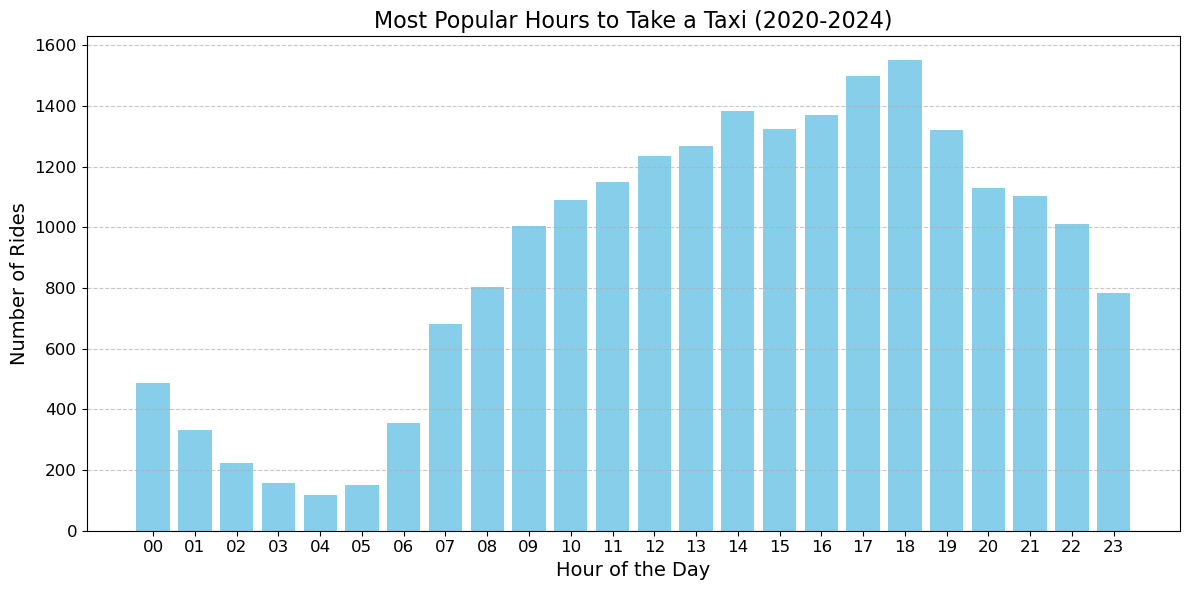

In [79]:
# Fetch the data from the database
taxi_hourly_data = get_data_for_visual_1()

# Plot the data
plot_visual_1(taxi_hourly_data)

### Visualization 2: What’s the most popular month to hire a cab or Uber?

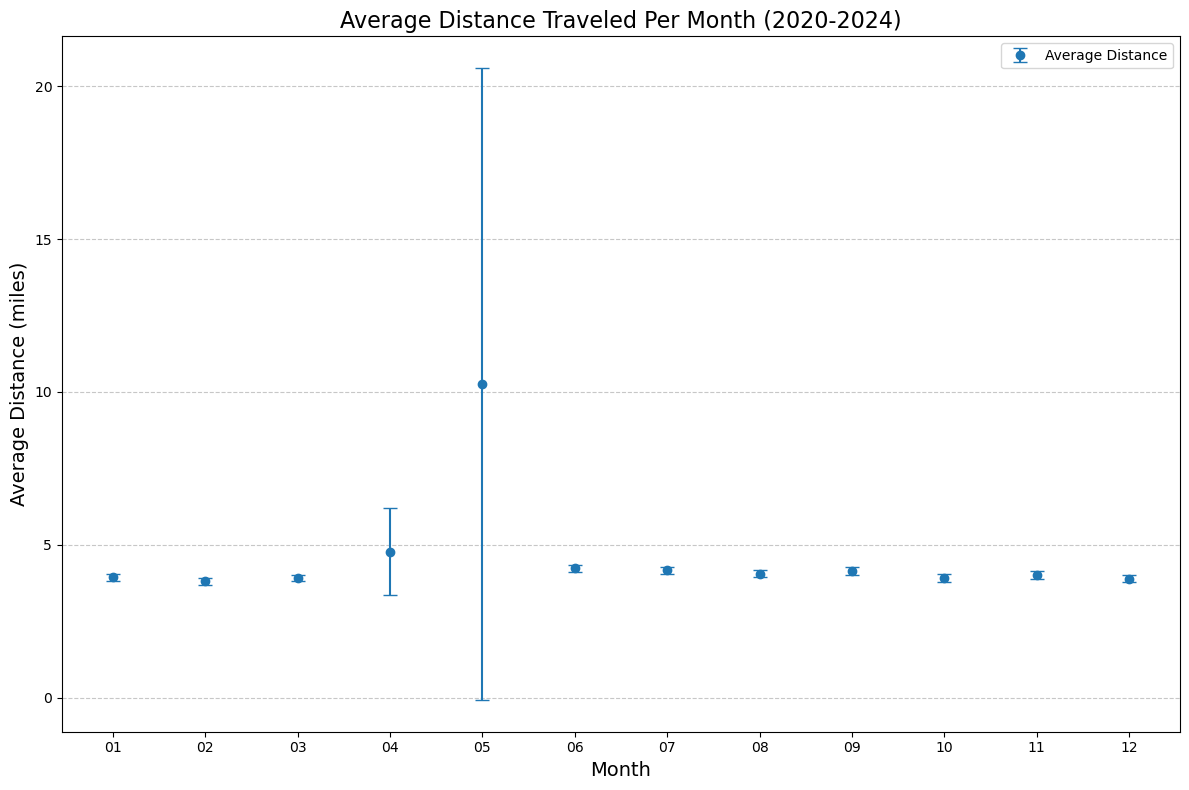

In [80]:
def get_data_for_visual_2():
    QUERY = """
    WITH monthly_distance AS (
        SELECT 
            strftime('%m', pickup_time) AS month, -- Extract month (01-12)
            trip_distance AS distance
        FROM taxi_trips
        WHERE pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT 
            strftime('%m', pickup_time) AS month, -- Extract month (01-12)
            trip_distance AS distance
        FROM uber_trips
        WHERE pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT 
        month, -- Month (01-12)
        distance -- Distance for each trip
    FROM monthly_distance
    """
    return pd.read_sql(QUERY, con=engine)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_visual_2(dataframe):
    # Group data by month and calculate statistics
    grouped = dataframe.groupby('month')['distance']
    avg_distance = grouped.mean()
    std_distance = grouped.std()
    count = grouped.count()

    # Calculate 90% confidence interval
    ci_lower = avg_distance - 1.645 * (std_distance / np.sqrt(count))
    ci_upper = avg_distance + 1.645 * (std_distance / np.sqrt(count))

    # Prepare data for plotting
    months = avg_distance.index.astype(int)  # Ensure months are integers
    avg_distance = avg_distance.values
    ci_lower = ci_lower.values
    ci_upper = ci_upper.values

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.errorbar(
        months, 
        avg_distance, 
        yerr=[avg_distance - ci_lower, ci_upper - avg_distance], 
        fmt='o', 
        capsize=5, 
        label='Average Distance'
    )

    # Add labels, title, and grid
    plt.xticks(months, labels=[f'{m:02d}' for m in months])
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Average Distance (miles)', fontsize=14)
    plt.title('Average Distance Traveled Per Month (2020-2024)', fontsize=16)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Fetch data and plot visualization
monthly_distance_data = get_data_for_visual_2()
plot_visual_2(monthly_distance_data)

### Visualization 3: Which day of the week is most popular for taking a ride to an NYC-based airport?

In [81]:
def get_data_for_visual_3():
    QUERY = """
    WITH airport_dropoffs AS (
        SELECT 
            strftime('%w', dropoff_time) AS day_of_week, -- Day of week (0=Sunday, 6=Saturday)
            CASE
                WHEN dropoff_lat BETWEEN 40.763589 AND 40.778865 AND dropoff_lon BETWEEN -73.891745 AND -73.854838 THEN 'LGA'
                WHEN dropoff_lat BETWEEN 40.639263 AND 40.651376 AND dropoff_lon BETWEEN -73.795642 AND -73.766264 THEN 'JFK'
                WHEN dropoff_lat BETWEEN 40.686794 AND 40.699680 AND dropoff_lon BETWEEN -74.194028 AND -74.165205 THEN 'EWR'
                ELSE NULL
            END AS airport
        FROM (
            SELECT dropoff_time, dropoff_lat, dropoff_lon FROM taxi_trips
            UNION ALL
            SELECT dropoff_time, dropoff_lat, dropoff_lon FROM uber_trips
        )
        WHERE 
            dropoff_time BETWEEN '2020-01-01' AND '2024-08-31' -- Time range
    )
    SELECT 
        day_of_week, -- Day of week (0=Sunday, 6=Saturday)
        airport, -- Airport name (LGA, JFK, EWR)
        COUNT(*) AS dropoff_count -- Number of drop-offs
    FROM airport_dropoffs
    WHERE airport IS NOT NULL -- Filter valid airports
    GROUP BY day_of_week, airport
    ORDER BY airport, day_of_week ASC;
    """
    # Execute the query and load results into a Pandas DataFrame
    return pd.read_sql(QUERY, con=engine)

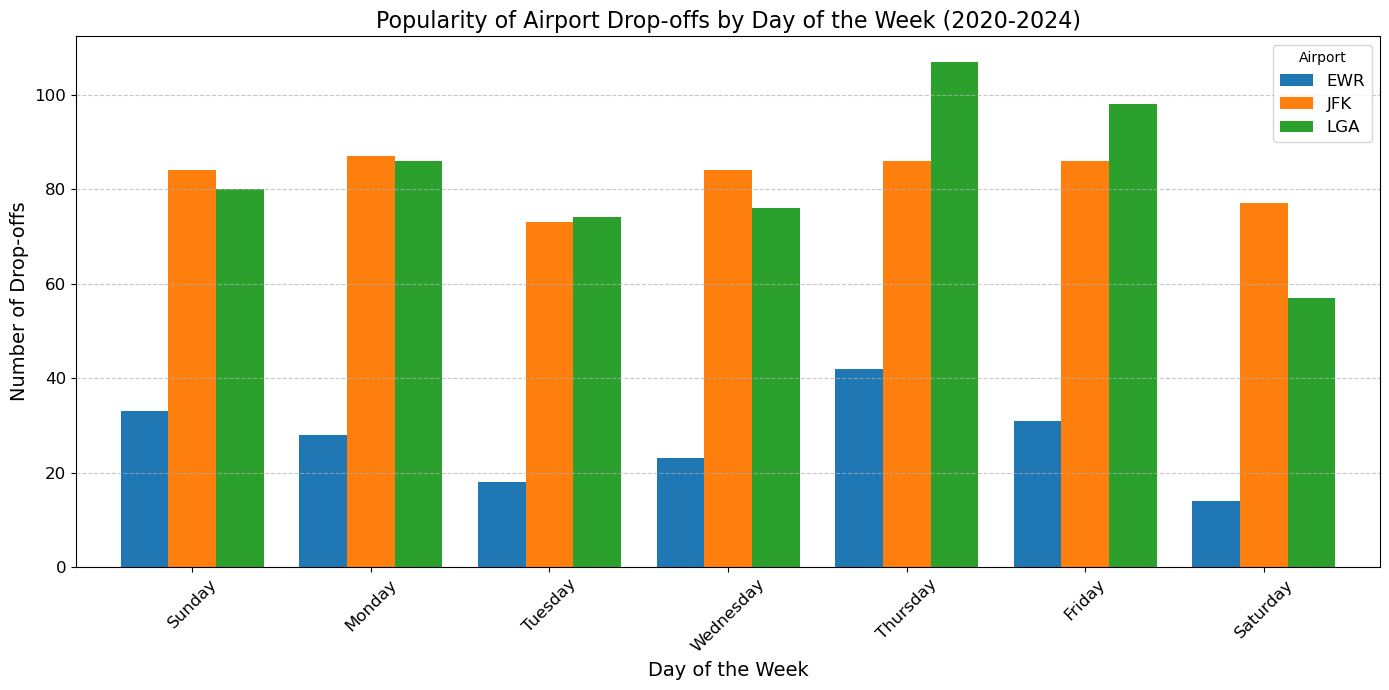

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_visual_3(dataframe):
    # Map day_of_week numbers to names
    day_mapping = {
        '0': 'Sunday',
        '1': 'Monday',
        '2': 'Tuesday',
        '3': 'Wednesday',
        '4': 'Thursday',
        '5': 'Friday',
        '6': 'Saturday'
    }
    dataframe['day_of_week'] = dataframe['day_of_week'].map(day_mapping)

    # Pivot the data for plotting
    pivoted_data = dataframe.pivot(index='day_of_week', columns='airport', values='dropoff_count')
    pivoted_data = pivoted_data.reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

    # Plot the data
    pivoted_data.plot(kind='bar', figsize=(14, 7), width=0.8)

    # Add labels, title, and legend
    plt.xlabel('Day of the Week', fontsize=14)
    plt.ylabel('Number of Drop-offs', fontsize=14)
    plt.title('Popularity of Airport Drop-offs by Day of the Week (2020-2024)', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Airport', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Fetch the data from the database
airport_dropoff_data = get_data_for_visual_3()

# Plot the visualization
plot_visual_3(airport_dropoff_data)

### Visualization 4: How much do hired rides earn in total fares monthly?

In [108]:
def get_data_for_visual_4():
    QUERY = """
    WITH monthly_fares AS (
        SELECT
            strftime('%Y-%m', pickup_time) AS month,
            'Taxi' AS ride_type,
            SUM(CAST(fare_amount AS FLOAT)) +
            SUM(CAST(tax AS FLOAT)) +
            SUM(CAST(tolls AS FLOAT)) +
            SUM(CAST(con_surcharge AS FLOAT)) +
            SUM(CAST(imp_surcharge AS FLOAT)) AS total_fare
            
        FROM taxi_trips
        WHERE 
            pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY month
        UNION ALL
        SELECT
            strftime('%Y-%m', pickup_time) AS month,
            'Uber' AS ride_type,
            SUM(CAST(fare_amount AS FLOAT)) +
            SUM(CAST(tax AS FLOAT)) +
            SUM(CAST(tolls AS FLOAT)) +
            SUM(CAST(con_surcharge AS FLOAT)) +
            SUM(CAST(tips AS FLOAT)) AS total_fare
        FROM uber_trips
        WHERE 
            pickup_time BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY month
    )
    SELECT 
        month,
        ride_type,
        total_fare
    FROM monthly_fares
    ORDER BY month, ride_type ASC;
    """
    return pd.read_sql(QUERY, con=engine)

In [109]:
import matplotlib.pyplot as plt
import numpy as np

def plot_visual_4(dataframe):
    # Separate Taxi and Uber data
    taxi_data = dataframe[dataframe['ride_type'] == 'Taxi']
    uber_data = dataframe[dataframe['ride_type'] == 'Uber']
    
    # Prepare months
    months = sorted(dataframe['month'].unique())
    x = np.arange(len(months))  # x-axis index
    
    # Total fares
    taxi_total = taxi_data.set_index('month')['total_fare'].reindex(months, fill_value=0)
    uber_total = uber_data.set_index('month')['total_fare'].reindex(months, fill_value=0)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Bar chart for Taxi and Uber
    ax.bar(x - 0.2, taxi_total, width=0.4, label='Taxi - Total Fare', color='orange', alpha=0.8)
    ax.bar(x + 0.2, uber_total, width=0.4, label='Uber - Total Fare', color='red', alpha=0.8)
    
    # Add labels and title
    ax.set_xlabel('Month (YYYY-MM)', fontsize=14)
    ax.set_ylabel('Earnings ($)', fontsize=14)
    ax.set_title('Monthly Total Fares (2020-2024)', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(months, rotation=45, fontsize=12)
    ax.legend(loc='upper left', fontsize=12)
    
    # Gridlines and layout adjustment
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

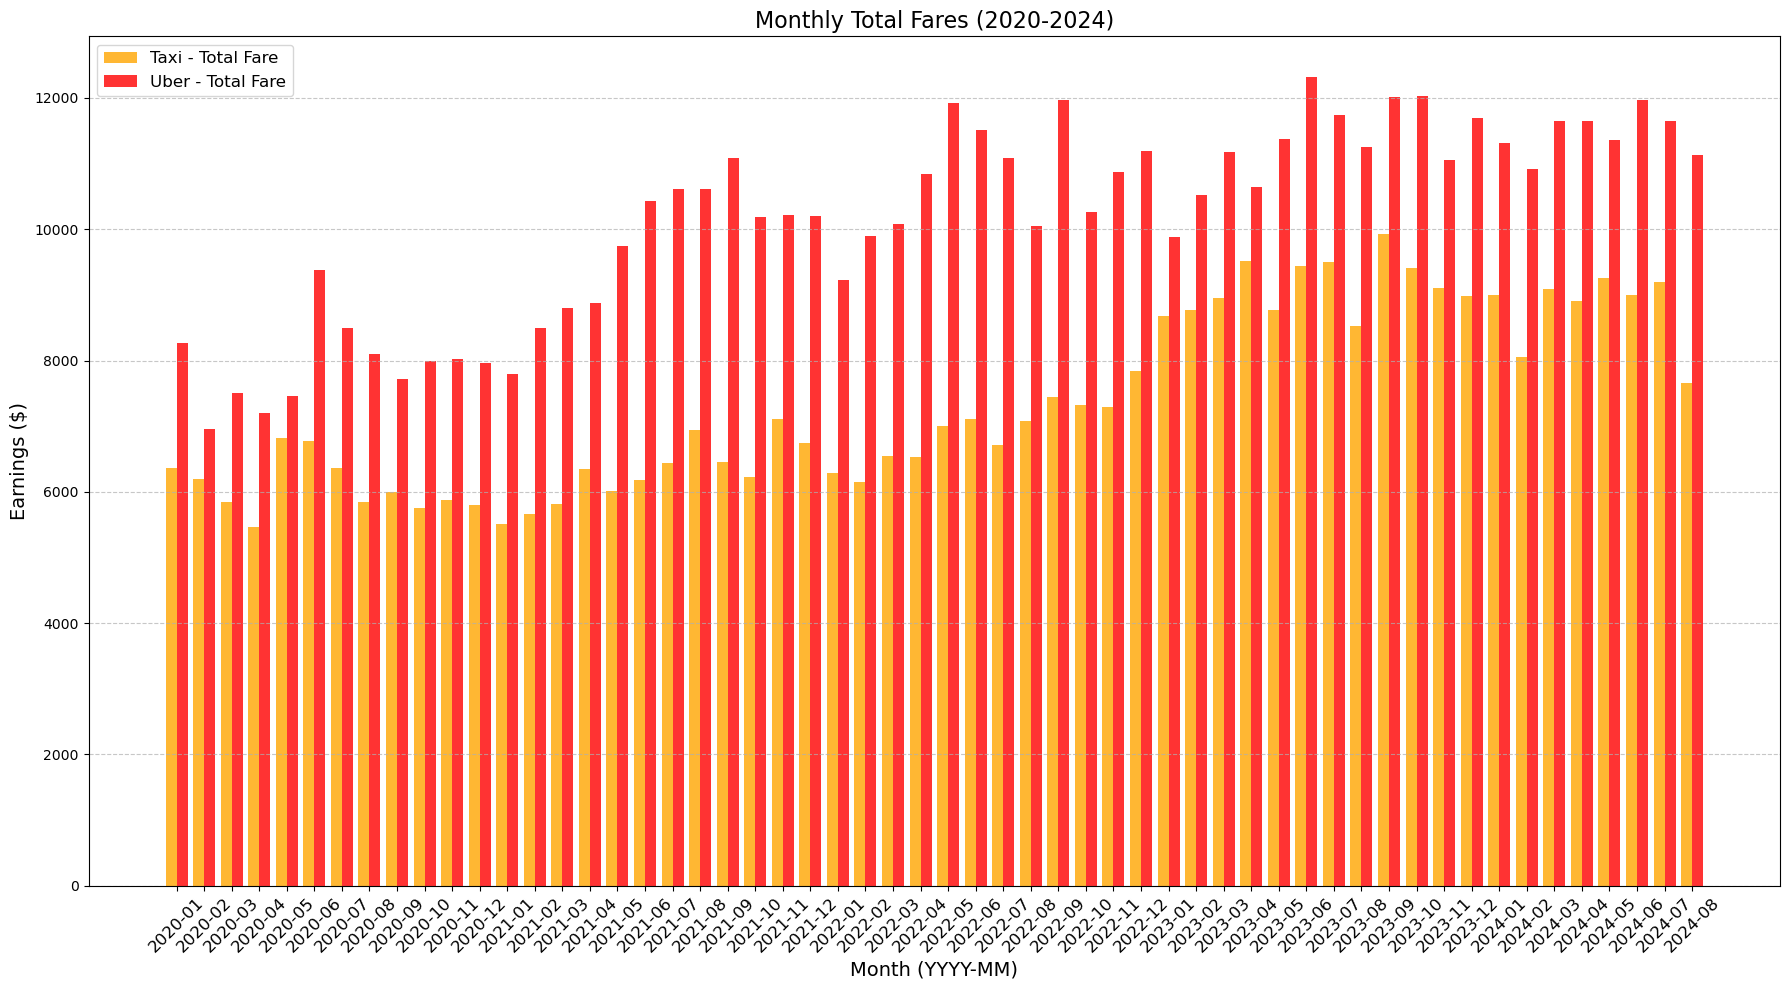

In [110]:
fare_data = get_data_for_visual_4()
plot_visual_4(fare_data)

### Visualization 5: Does precipitation or distance traveled affect the amount of tip?

In [86]:
def get_data_for_visual_5():
    QUERY = """
    WITH taxi_data AS (
        SELECT 
            'Taxi' AS ride_type,
            CAST(tip AS FLOAT) AS tip_amount,
            CAST(trip_distance AS FLOAT) AS distance,
            CAST(hw.precipitation AS FLOAT) AS precipitation
        FROM taxi_trips tt
        LEFT JOIN hourly_weather hw
        ON strftime('%Y-%m-%d %H', tt.pickup_time) = strftime('%Y-%m-%d %H', hw.datetime)
        WHERE 
            tt.pickup_time BETWEEN '2022-01-01' AND '2023-12-31'
    ),
    uber_data AS (
        SELECT 
            'Uber' AS ride_type,
            CAST(tips AS FLOAT) AS tip_amount,
            CAST(trip_distance AS FLOAT) AS distance,
            CAST(hw.precipitation AS FLOAT) AS precipitation
        FROM uber_trips ut
        LEFT JOIN hourly_weather hw
        ON strftime('%Y-%m-%d %H', ut.pickup_time) = strftime('%Y-%m-%d %H', hw.datetime)
        WHERE 
            ut.pickup_time BETWEEN '2022-01-01' AND '2023-12-31'
    )
    SELECT * FROM taxi_data
    UNION ALL
    SELECT * FROM uber_data;
    """
    df = pd.read_sql(QUERY, con=engine)
    
    df['tip_amount'] = pd.to_numeric(df['tip_amount'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['precipitation'] = pd.to_numeric(df['precipitation'], errors='coerce')
    return df

In [87]:
def plot_visual_5(dataframe):
    
    dataframe = dataframe.dropna(subset=['tip_amount', 'distance', 'precipitation'])

    # Split data into Taxi and Uber rides
    taxi_data = dataframe[dataframe['ride_type'] == 'Taxi']
    uber_data = dataframe[dataframe['ride_type'] == 'Uber']

    # Remove outliers
    taxi_data = taxi_data[(taxi_data['tip_amount'] <= 50) & (taxi_data['distance'] <= 100) & (taxi_data['precipitation'] <= 5)]
    uber_data = uber_data[(uber_data['tip_amount'] <= 50) & (uber_data['distance'] <= 100) & (uber_data['precipitation'] <= 5)]

    # Create the figure and 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Scatter plot for Taxi (Tip vs Distance)
    axes[0, 0].scatter(taxi_data['distance'], taxi_data['tip_amount'], alpha=0.5, color='blue')
    axes[0, 0].set_title('Taxi: Tip vs Distance', fontsize=14)
    axes[0, 0].set_xlabel('Distance (miles)', fontsize=12)
    axes[0, 0].set_ylabel('Tip Amount ($)', fontsize=12)

    # Scatter plot for Uber (Tip vs Distance)
    axes[0, 1].scatter(uber_data['distance'], uber_data['tip_amount'], alpha=0.5, color='green')
    axes[0, 1].set_title('Uber: Tip vs Distance', fontsize=14)
    axes[0, 1].set_xlabel('Distance (miles)', fontsize=12)
    axes[0, 1].set_ylabel('Tip Amount ($)', fontsize=12)

    # Scatter plot for Taxi (Tip vs Precipitation)
    axes[1, 0].scatter(taxi_data['precipitation'], taxi_data['tip_amount'], alpha=0.5, color='purple')
    axes[1, 0].set_title('Taxi: Tip vs Precipitation', fontsize=14)
    axes[1, 0].set_xlabel('Precipitation (inches)', fontsize=12)
    axes[1, 0].set_ylabel('Tip Amount ($)', fontsize=12)

    # Scatter plot for Uber (Tip vs Precipitation)
    axes[1, 1].scatter(uber_data['precipitation'], uber_data['tip_amount'], alpha=0.5, color='orange')
    axes[1, 1].set_title('Uber: Tip vs Precipitation', fontsize=14)
    axes[1, 1].set_xlabel('Precipitation (inches)', fontsize=12)
    axes[1, 1].set_ylabel('Tip Amount ($)', fontsize=12)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

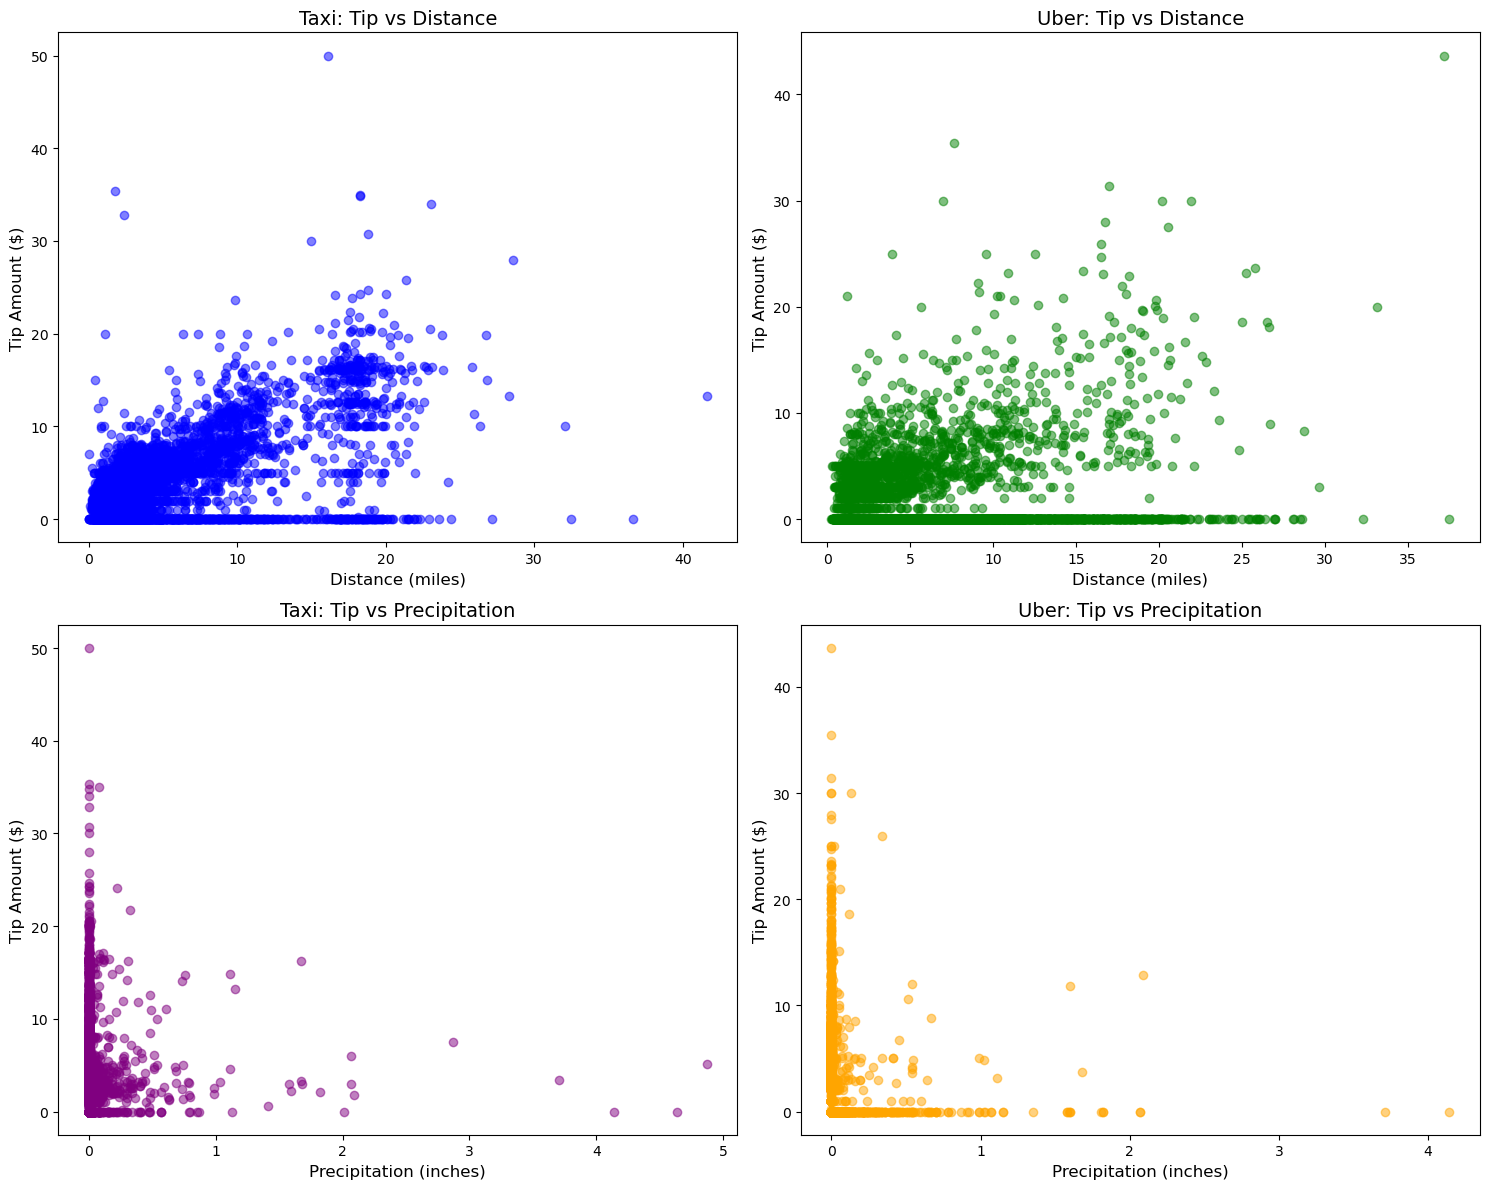

In [88]:
# Fetch the data from the database
visual_5_data = get_data_for_visual_5()

# Plot the visualization
plot_visual_5(visual_5_data)

### Visualization 6: 

In [97]:
from sqlalchemy import create_engine
import pandas as pd
import folium
from folium.plugins import HeatMap

In [98]:
# Define the database connection
DATABASE_URL = "sqlite:///project.db"  # Replace with your database file path
engine = create_engine(DATABASE_URL)

In [99]:
# Fetch data for visualization
def get_data_for_visual_6():
    QUERY = """
    SELECT 
        pickup_lat AS latitude, 
        pickup_lon AS longitude
    FROM taxi_trips
    WHERE strftime('%Y', pickup_time) = '2020'
    UNION ALL
    SELECT 
        pickup_lat AS latitude, 
        pickup_lon AS longitude
    FROM uber_trips
    WHERE strftime('%Y', pickup_time) = '2020';
    """
    return pd.read_sql(QUERY, con=engine)

# Plot the heatmap
def plot_visual_6(dataframe):
    dataframe = dataframe.dropna(subset=['latitude', 'longitude'])

    # Create the Folium map
    m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

    # Prepare the heatmap data
    heat_data = dataframe[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data, radius=8, blur=10, max_zoom=1).add_to(m)

    # Save the map
    m.save("heatmap_2020.html")
    return m

# Fetch and visualize the data
visual_6_data = get_data_for_visual_6()
heatmap = plot_visual_6(visual_6_data)
heatmap